# IEQ and Survey Response Analysis
Exploring the relationship between the categorical survey responses from the EMA and the IEQ measurements from the Beacon

In [2]:
import warnings
warnings.filterwarnings('ignore')

# IEQ Prior to Mood Reports
We want to know if the IEQ affected participants' mood scores when EMAs were submitted at home and participants were home prior to submission.

In [3]:
import os
import sys
sys.path.append('../')

from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

from scipy import stats

<a id='toc'></a>

# Table of Contents

1. [Data Import](#data_import)
2. [Inspection](#inspection)
2. [Pre-Processing](#pre_processing)
4. [Analysis](#analysis)

---

<a id='data_import'></a>

[Back to ToC](#toc)
# Data Import
We have two datasets to import:

## EMAs Completed at Home
Intersection between GPS coordinates, home address, and the completion of the EMAs.

In [4]:
ema = pd.read_csv("../data/processed/beiwe-ema_at_home_v2-ux_s20.csv",index_col="timestamp",parse_dates=["timestamp"],infer_datetime_format=True)
ema.head()

,beiwe,content,stress,lonely,sad,energy,redcap,beacon,time_at_home
timestamp,,,,,,,,,
2020-05-15 09:21:05,mm69prai,1.0,0.0,1.0,1.0,1.0,62,13.0,10412.0
2020-05-15 09:25:04,vr9j5rry,2.0,0.0,0.0,0.0,3.0,34,25.0,29405.0
2020-05-15 12:02:43,kyj367pi,2.0,0.0,1.0,0.0,2.0,10,1.0,3774.0
2020-05-15 12:59:31,lkkjddam,1.0,1.0,2.0,1.0,2.0,12,21.0,5536.0
2020-05-15 17:28:54,9jtzsuu8,2.0,1.0,0.0,0.0,2.0,36,15.0,31643.0


## IEQ Data

In [5]:
ieq = pd.read_csv('../data/processed/beacon-ux_s20.csv',index_col="timestamp",parse_dates=["timestamp"],infer_datetime_format=True)
ieq.drop(["beacon","redcap","pm1_number","pm2p5_number","pm10_number","pm1_mass","pm10_mass","no2","lux","co"],axis=1,inplace=True)
ieq.head()

,tvoc,co2,pm2p5_mass,temperature_c,rh,beiwe,fitbit
timestamp,,,,,,,
2020-06-08 13:00:00,59.283485,NaN,24.767709,16.244700,46.586667,kyj367pi,24.0
2020-06-08 13:02:00,59.501238,NaN,25.379307,16.257887,46.581250,kyj367pi,24.0
2020-06-08 13:04:00,60.484807,NaN,24.874103,16.269523,46.597059,kyj367pi,24.0
2020-06-08 13:06:00,61.532057,NaN,24.503767,16.279865,46.619444,kyj367pi,24.0
2020-06-08 13:08:00,62.381287,NaN,24.824221,16.289119,46.639474,kyj367pi,24.0


---

<a id='inspection'></a>

[Back to ToC](#toc)
# Inspection
Various functions and initial looks at the raw data.

## Typical Times at Home
We can start by inspecting the typical times that participants were at home prior to submitting their survey.

In [6]:
def plot_time_at_home(df,unit="minutes",bins=np.arange(0,35,5)):
    """plots histogram of times spent at home with given unit and bins"""
    fig, ax = plt.subplots()
    if unit == "minutes":
        divisor = 60
    elif unit == "hours":
        divisor = 3600
    else:
        divisor = 1
        unit = "seconds"
        
    ax.hist(ema["time_at_home"]/divisor,bins=bins,edgecolor="black",color="grey")
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

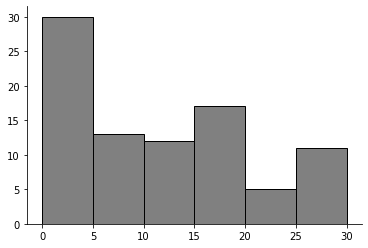

In [7]:
plot_time_at_home(ema)

[Back to Inspection](#inspection)

---

<a id='pre_processing'></a>

[Back to ToC](#toc)
# Pre-Processing

## Getting IEQ Summary Stats Prior to Submission
The summary stats that we will consider during the period prior to submission are:
* **Mean**: mean concentration
* **Max**: max concentration
* **Sum**: cumulative concentration 
* **Range**: difference in maximum and minimum concentration
* **Delta**: change in concentration between initial occupancy and EMA submission (final - initial)

In [8]:
def get_ieq_measurements(ieq, ema, window=10, min_time_at_home=60):
    """
    Summarizes IEQ measurements for a given period prior to submission of the EMA
    
    Parameters
    ----------
    ieq : DataFrame
        IEQ data for a given participant
    ema: DataFrame
        EMA submissions for a given participant
    window : int, boolean, default 10
        Number of minutes to consider before EMA submission. If True, then uses the entire 
        time prior to submission as determined by GPS traces from Beiwe.
    min_time_at_home : int, default 60
        minimum number of seconds the participant has to be at home
    
    Returns
    -------
    ema_and_iaq : DataFrame
        original dataframe with summarized IEQ parameters
    """
    # ensuring timestamp is index of ema
    try:
        ema.set_index("timestamp",inplace=True)
    except KeyError:
        # assuming "timestamp" is the index
        pass
    ema_and_ieq = pd.DataFrame()
    for pt in ema["beiwe"].unique():
        ieq_pt = ieq[ieq["beiwe"] == pt]
        ema_pt = ema[ema["beiwe"] == pt]
        ieq_pt.drop("beiwe",axis=1,inplace=True)
        # summary stat DFs
        ieq_prior_mean = pd.DataFrame()
        ieq_prior_max = pd.DataFrame()
        ieq_prior_sum = pd.DataFrame()
        ieq_prior_range = pd.DataFrame()
        ieq_prior_delta = pd.DataFrame()
        for t in ema_pt.index:
            if window == True:
                try:
                    t_at_home = ema_pt.loc[t,"time_at_home"]
                    if t_at_home > min_time_at_home:
                        s = t - timedelta(seconds=t_at_home)
                    else:
                        s = t
                except KeyError as e:
                    print(e)
                    return
            else:
                s = t - timedelta(minutes=window)
            ieq_prior = ieq_pt[s:t]
            if len(ieq_prior) > 0:
                ieq_prior_mean = pd.concat([ieq_prior_mean,ieq_prior.mean(axis=0)],axis=1)
                ieq_prior_max = pd.concat([ieq_prior_max,ieq_prior.max(axis=0)],axis=1)
                ieq_prior_range = pd.concat([ieq_prior_range,ieq_prior.max(axis=0) - ieq_prior.min(axis=0)],axis=1)
                ieq_prior_delta = pd.concat([ieq_prior_delta,ieq_prior.iloc[-1,:] - ieq_prior.iloc[0,:]],axis=1)
                ieq_prior_sum = pd.concat([ieq_prior_sum,ieq_prior.sum(axis=0,numeric_only=True)],axis=1)

        # mean
        ieq_prior_mean = ieq_prior_mean.T
        ieq_prior_mean.columns  = [col+"_mean" for col in ieq_prior_mean.columns]
        # max
        ieq_prior_max = ieq_prior_max.T
        ieq_prior_max.columns  = [col+"_max" for col in ieq_prior_max.columns]
        # sum
        ieq_prior_sum = ieq_prior_sum.T
        ieq_prior_sum.columns  = [col+"_sum" for col in ieq_prior_sum.columns]
        # range
        ieq_prior_range = ieq_prior_range.T
        ieq_prior_range.columns  = [col+"_range" for col in ieq_prior_range.columns]
        # delta
        ieq_prior_delta = ieq_prior_delta.T
        ieq_prior_delta.columns  = [col+"_delta" for col in ieq_prior_delta.columns]

        ema_ieq_pt = pd.concat([ema_pt.reset_index(),ieq_prior_mean.reset_index(drop=True),ieq_prior_max.reset_index(drop=True),ieq_prior_sum.reset_index(drop=True),ieq_prior_range.reset_index(drop=True),ieq_prior_delta.reset_index(drop=True)],axis=1)
        ema_and_ieq = ema_and_ieq.append(ema_ieq_pt)

    return ema_and_ieq

In [9]:
ema_ieq = get_ieq_measurements(ieq,ema,window=True)

In [10]:
print("Number of Participants:", len(ema_ieq.dropna()["beiwe"].unique()))

Number of Participants: 20


## Discontent Over Content
Three of the four mood scores are negative i.e. for a good score, you want to rate your mood low whereas the `content` score is the opposite. We can get around this by defining a `discontent` score which will simply be the opposite of `content`.

In [11]:
ema_ieq["discontent"] = 3 - ema_ieq["content"]

## Binarizing Dataset
Various analyses might perform better if we binarize the mood scores and/or the IEQ measurements. In the following cells, we create all the possible combinations of binarized datasets.

### "Low" and "High" Mood
0 and 1 -> Low

2 and 3 -> High

In [12]:
ema_bi_ieq = ema_ieq.copy()
for mood in ["content","discontent","stress","lonely","sad"]:
    if mood in ["content","discontent"]:
        ema_bi_ieq[mood] = ["low" if score < 2 else "high" for score in ema_bi_ieq[mood]]
    else:
        ema_bi_ieq[mood] = ["low" if score == 0 else "high" for score in ema_bi_ieq[mood]]

### Binarizing IAQ Based on Participant-Specific Values
Rather than consider IAQ thresholds which provide a host of their own issues (participant adaptation, measurements all above or below threshold, etc.), we binarize IAQ as good or bad based on the mean concentration the participant experienced during the study period. 

In [13]:
def encode_ieq(value, threshold):
    """Scores the IEQ parameter"""
    if value <= threshold:
        return "high"
    else:
        return "low"

In [14]:
def get_binary_ieq(df,raw_ieq,pollutants=["co2","tvoc","pm2p5_mass","temperature_c","rh"]):
    """
    Gets the binary encoding of the vars in pollutants for each participant
    
    Inputs:
        - df: dataframe with mean pollutant concentrations
        - raw_ieq: dataframe of the unaltered ieq data from the entire deployment
        - pollutants: list of strings corresponding to the IEQ parameters of interest - must have corresponding columns in the other two dataframes
    """
    df_bi = pd.DataFrame()
    for pt in df["beiwe"].unique():
        df_pt = df[df["beiwe"] == pt]
        ieq_pt = raw_ieq[raw_ieq["beiwe"] == pt]
        for pollutant in pollutants:
            try:
                mean_night = np.nanmean(ieq_pt[f"{pollutant}"])
            except KeyError as e:
                print(f"Exiting: {e} not in the raw IEQ data")
                return
            
            df_pt[f"{pollutant}_binary"] = df_pt.apply(lambda x: encode_ieq(x[f"{pollutant}_mean"],mean_night), axis="columns")

        df_bi = df_bi.append(df_pt)

    return df_bi

In [15]:
ema_bi_ieq_bi = get_binary_ieq(ema_bi_ieq,ieq)

[Back to Pre-Processing](#pre_processing)

---

<a id='analysis'></a>

[Back to ToC](#toc)
# Analysis
The following is the general analysis that follows:
1. **[IEQ distributions for low and high mood](#ieq_distributions)**: This process helps us avoid determining if IEQ parameters are "good" or "bad" by simply looking at the meausrements made prior to the EMA submitted at home. We do have to consider analysis on two-levels:
    1. **Population-Level**: A general overview that can pull-in bias from participants
    2. **Individual-Level**: More specific analysis where we can combine the results on a per-participant level in a meaningful way to help reduce bias.
2. **[IEQ and mood summarized over the _entire_ study](#ieq_and_mood)**: Summarize the IEQ parameters in various ways and summarize the mood scores and compare them. Each participant corresponds to one datapoint. We still only consider the EMAs that are completed at home though since _so_ many other factors could go into determining the mood elsewhere.
2. **[Time dependence on mood](#time_dependence)**: This analysis considers the time spent at home as a parameter in addition to the type of activity conducted during that time. We need to consider such things as:
    1. **Acclimation**: Do participants tend to acclimate to their IEQ parameters after a while? 
    2. **Exposure estimates**: Inhalation rates might vary by participant so concentrations might be lower for one participant, but if their inhalation rate is greater then they are really exposed to a _greater_ concentration.
    3. **Activity level**: we can get this information from Fitbit and/or Beiwe, but on a more macro-level the big question is whether or not to include sleeping times since you are unconscious during this period.
3. **[Contingency tables](#contingency)**: A more statistical look at the relationship between low and high IEQ and mood parameters
4. **[Mood and ventilation rate](#mood_and_ach)**: Rather than consider all IEQ parameters, perhaps we can simplify things to just the ventilation rate and use that as a proxy for IAQ.

<a id='ieq_distributions'></a>

## IEQ Distributions for Low and High Mood Scores
The first part of the analysis is examining the difference in IEQ distributions when participants moods are low or high. 

### Initial Impressions
By using stripplots we can see if there are any noticeable tendencies

In [16]:
def plot_strips(ieq_param="co2",summary_stat="mean"):
    """"""
    fig, axes = plt.subplots(1,4,figsize=(16,4),sharey=True,gridspec_kw={"wspace":0.05})
    for mood, ax in zip(["content","stress","lonely","sad"],axes.flat):
        sns.stripplot(x=mood,y=f"{ieq_param}_{summary_stat}",data=ema_ieq,
                      alpha=0.5,ax=ax)
        ax.set_xlabel(mood.title())
        ax.set_ylabel("")
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
    axes[0].set_ylabel(f"{summary_stat.title()} {visualize.get_pollutant_label(ieq_param)} ({visualize.get_pollutant_units(ieq_param)})")
    
    plt.show()
    plt.close()
        

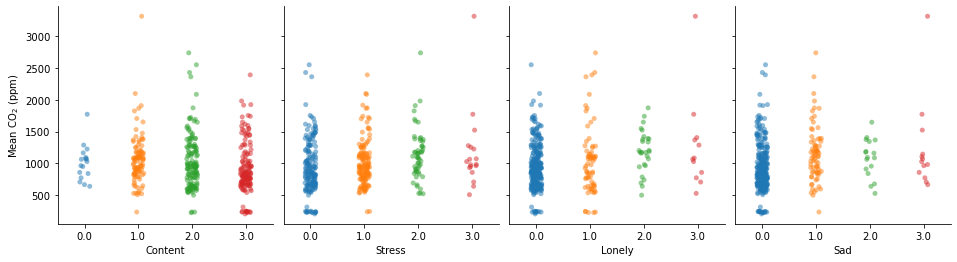

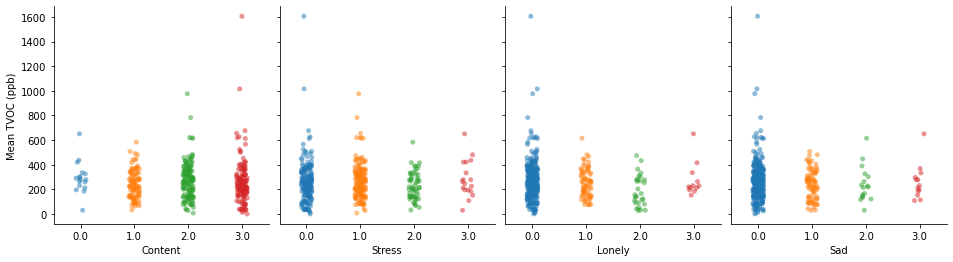

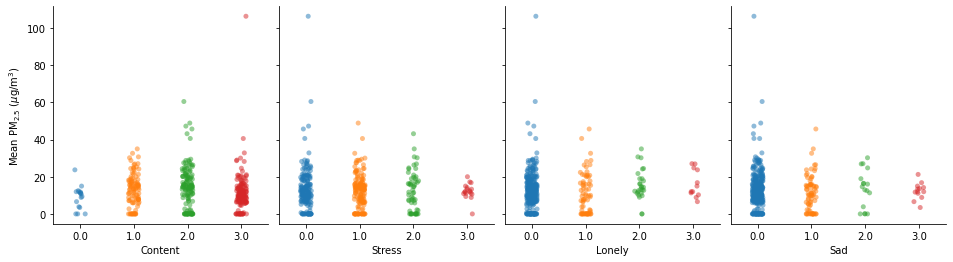

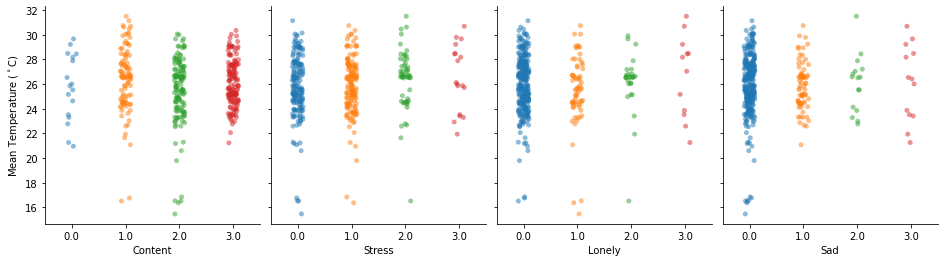

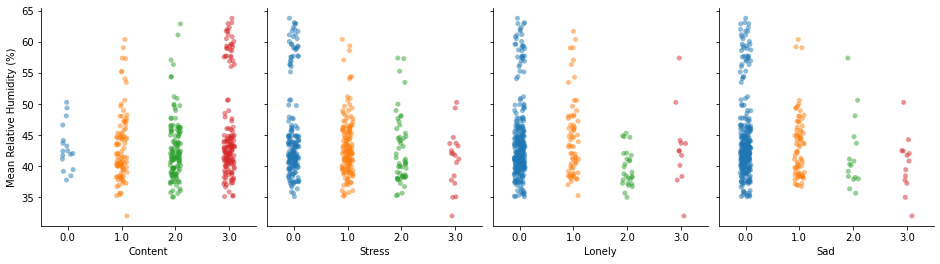

In [17]:
for ieq_param in ["co2","tvoc","pm2p5_mass","temperature_c","rh"]:
    plot_strips(ieq_param=ieq_param)

### Aggregate
Since we had the code to visualize and calculate p-values, we pull that in here and visualize the distributions in addition to providing the p-values.

In [18]:
def plot_mood_violin_per_ieq(df_in,ieq_params=["co2","tvoc","pm2p5_mass","temperature_c","rh"],summary_stat="mean",moods=["discontent","stress","lonely","sad"]):
    """"""
    legend_fs = 22
    tick_fs = 24
    label_fs = 26
    title_fs = 32
    # creating dictionary to store p-values
    ttest_results = {}
    fig, axes = plt.subplots(len(ieq_params),1,figsize=(4*len(moods),4*len(ieq_params)),sharex=True)
    for ieq_param, title, ax in zip(ieq_params,["a","b","c","d","e","f"],axes.flat):
        df_expanded = df_in.melt(id_vars=[c for c in df_in.columns if c.endswith(summary_stat)],value_vars=moods)
        sns.violinplot(x="variable",y=f"{ieq_param}_{summary_stat}",hue="value",data=df_expanded,
                       split=True,inner=None,hue_order=["low","high"],palette={"low":"white","high":"#bf5700"},cut=0,ax=ax)
        # x-axis
        ax.set_xticklabels([mood.title() for mood in moods],fontsize=tick_fs)
        ax.set_xlabel("")
        # y-axis
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=tick_fs)
        ax.set_ylabel(visualize.get_label(ieq_param),fontsize=label_fs)
        # remainder
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        if ieq_param == "rh":
            ax.legend(loc="upper center",bbox_to_anchor=(0.5,-0.075),frameon=False,ncol=2,fontsize=legend_fs,title_fontsize=tick_fs,title="Mood Score")
        else:
            ax.get_legend().remove()
        
        pvals = pd.DataFrame()
        for mood in moods:
            df = df_expanded[df_expanded["variable"] == mood]
            low_vals = df[df["value"] == "low"]
            high_vals = df[df["value"] == "high"]
            #print(f"Number of high:\t{len(high_vals)}\nNumber of low:\t{len(low_vals)}")
            _, p = stats.ttest_ind(low_vals[f"{ieq_param}_{summary_stat}"],high_vals[f"{ieq_param}_{summary_stat}"], equal_var=True, nan_policy="omit")
            pvals = pvals.append(pd.DataFrame({"mood":[mood],"low":[len(low_vals)],"high":[len(high_vals)],
                                               "mean_low":[np.nanmean(low_vals[f"{ieq_param}_{summary_stat}"])],"mean_high":np.nanmean(high_vals[f"{ieq_param}_{summary_stat}"]),"p_val":[p]}))

        ttest_results[ieq_param] = pvals.set_index("mood")

        # Annotating with p-values
        xlocs = ax.get_xticks()
        ax.text(ax.get_xlim()[0],ax.get_ylim()[1],"          p:",ha="center",va="bottom",fontsize=tick_fs)
        for xloc, p in zip(xlocs,ttest_results[ieq_param]["p_val"]):
            weight="bold" if p < 0.05 else "normal"
            val = round(p,3) if p > 0.001 else "< 0.001"
            ax.text(xloc,ax.get_ylim()[1],val,fontsize=tick_fs,ha="center",va="bottom",weight=weight)
        
    plt.show()
    plt.close()
    
    return ttest_results

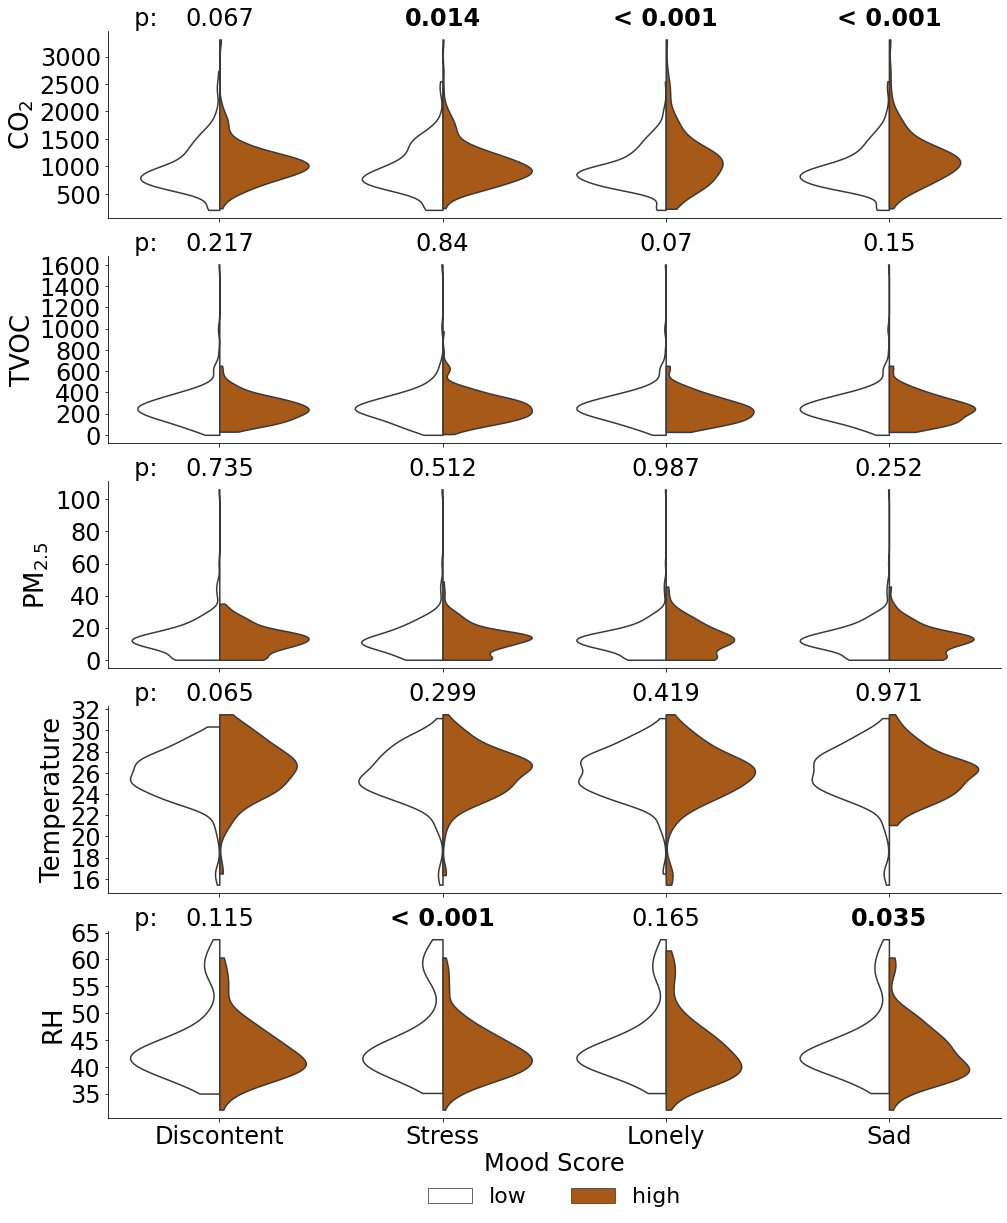

In [19]:
ieq_dist_ttest = plot_mood_violin_per_ieq(ema_bi_ieq,summary_stat="mean")

In [20]:
ieq_dist_ttest

{'co2':             low  high    mean_low    mean_high     p_val
 mood                                                    
 discontent  589   232  971.650317  1054.560343  0.066945
 stress      374   447  938.728258  1040.306224  0.014015
 lonely      552   269  954.045391  1105.335650  0.000948
 sad         578   243  940.669737  1149.991778  0.000006,
 'tvoc':             low  high    mean_low   mean_high     p_val
 mood                                                   
 discontent  589   232  268.256891  247.460117  0.217231
 stress      374   447  263.969528  260.853403  0.839684
 lonely      552   269  270.738404  239.785666  0.070394
 sad         578   243  268.843436  243.888418  0.149611,
 'pm2p5_mass':             low  high   mean_low  mean_high     p_val
 mood                                                 
 discontent  589   232  12.943174  12.560288  0.735148
 stress      374   447  13.209516  12.531538  0.512379
 lonely      552   269  12.836763  12.818229  0.987215
 sad

### Individual Relationship

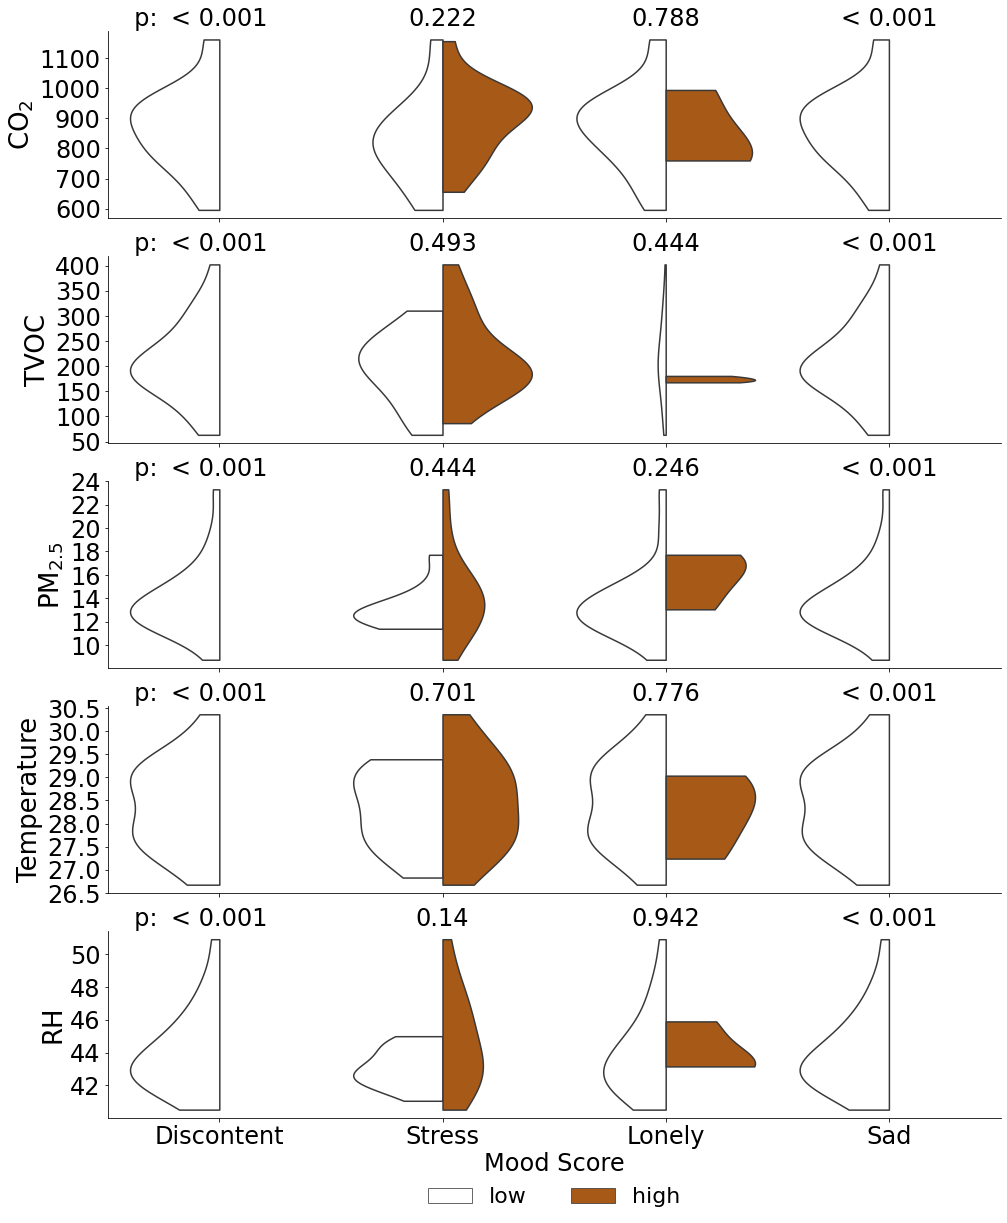

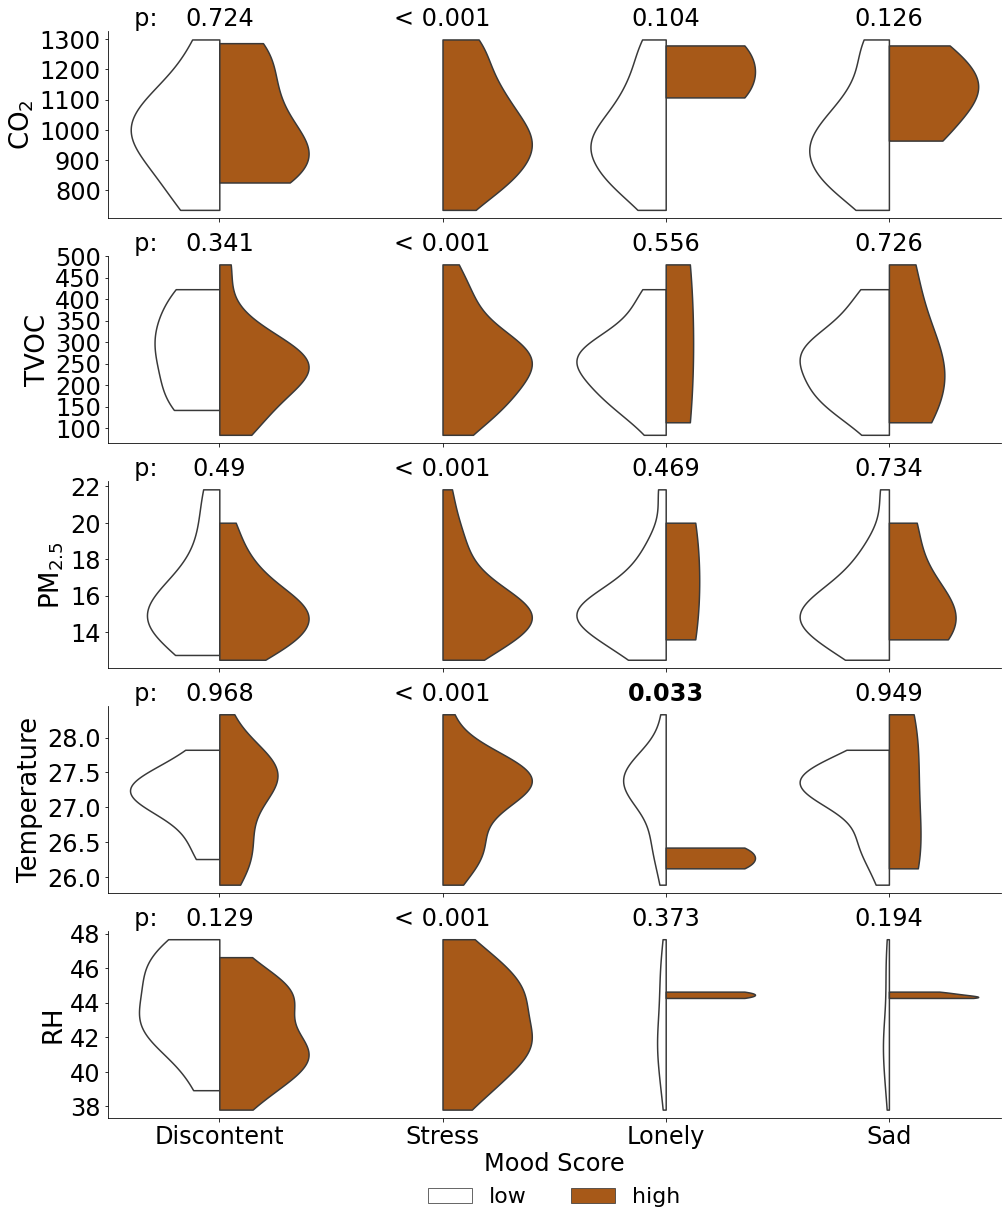

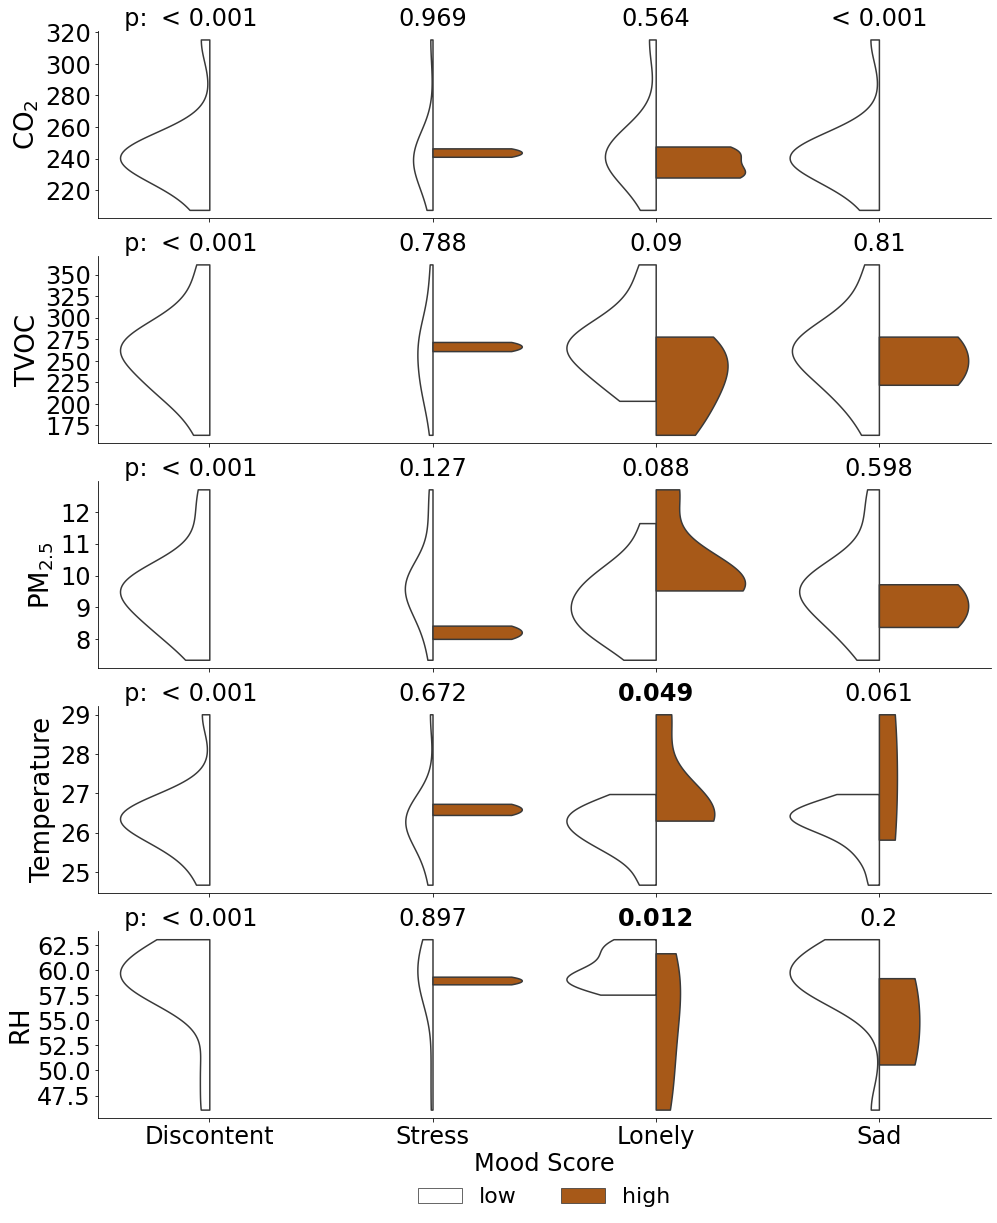

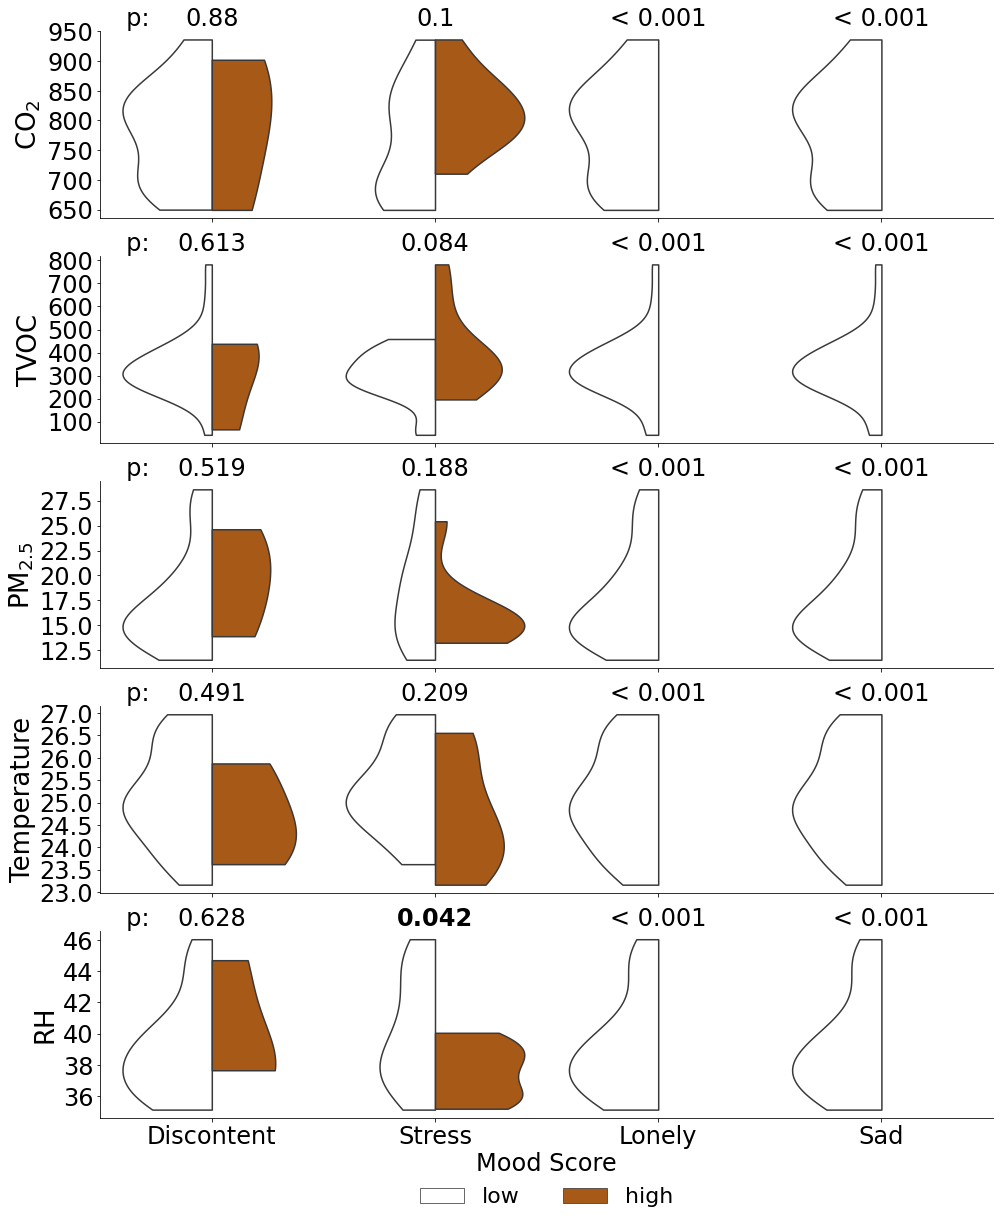

In [21]:
for pt in ema_bi_ieq["beiwe"].unique():
    ema_bi_ieq_pt = ema_bi_ieq[ema_bi_ieq["beiwe"] == pt]
    if len(ema_bi_ieq_pt) > 40:
        ieq_dist_ttest = plot_mood_violin_per_ieq(ema_bi_ieq_pt,summary_stat="mean")

<div class="alert alert-block alert-danger">

We don't have a sufficient amount of data to test the effects on an individual level.
    
</div>

[Back to Analysis](#analysis)

---

<a id='ieq_and_mood'></a>

## IEQ and Mood

In [26]:
def scatter_ieq_and_mood(df_ieq,df_mood,ieq_params=["co2","tvoc","pm2p5_mass","temperature_c","rh"],moods=["discontent","stress","lonely","sad"],ieq_stat="mean",mood_stat="mean"):
    """
    Scatters the IEQ and mood during the entire study
    """
    for pt in df_ieq["beiwe"].unique():
        ieq_pt = df_ieq[df_ieq["beiwe"] == pt]
        mood_pt = df_mood[df_mood["beiwe"] == pt]
        if len(ieq_pt) > 0 and len(mood_pt) > 0:
            _, ax = plt.subplots(len(ieq_params),len(moods),figsize=(4*len(moods),4*len(ieq_params)))
            

In [25]:
np.std(ieq[["co2","pm2p5_mass"]])

co2           445.085265
pm2p5_mass     12.631164
dtype: float64

In [26]:
scatter_ieq_and_mood(ieq,mood)

[Back to Analysis](#analysis)

---

<a id='time_dependence'></a>

## Time Dependence on Exposure at Home on Mood
With the amount of time at home, we can use this time to see if the mood scores are influenced by the time the participant is exposed to the pollution at home.

### Time at Home Only
We can start by looking at the time at home in a vacuum without considering IEQ's effect at all.

In [158]:
def plot_mood_on_time(df,mood="content",interval=15,max_t=600):
    _, ax = plt.subplots(figsize=(16,4))
    df["minutes_at_home"] = df["time_at_home"] / 60
    scores = []
    ns = []
    for cutoff1, cutoff2 in zip(np.arange(0,max_t-interval,interval),np.arange(interval,max_t,interval)):
        ema_by_cutoff = df[(df["minutes_at_home"] >= cutoff1) & (df["minutes_at_home"] <= cutoff2)]
        scores.append(ema_by_cutoff.mean(axis=0)[mood])
        ns.append(len(ema_by_cutoff))
        
    sc = ax.scatter(np.arange(interval,max_t,interval),scores,s=100,c=ns,cmap="coolwarm_r",edgecolor="black")
    plt.colorbar(sc)

    ax.set_ylim([0,3])
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)
    plt.show()
    plt.close()

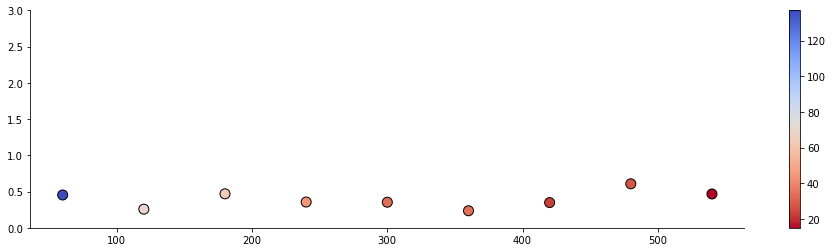

In [174]:
plot_mood_on_time(ema,"sad",interval=60)

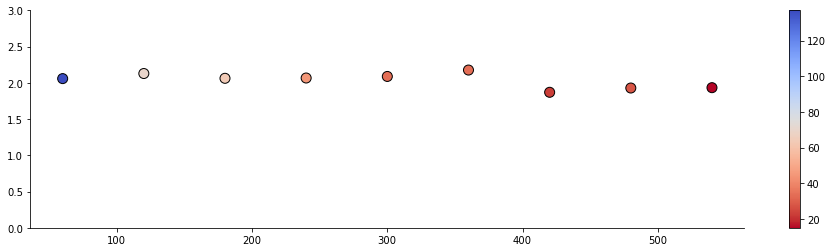

In [175]:
plot_mood_on_time(ema,"content",interval=60)

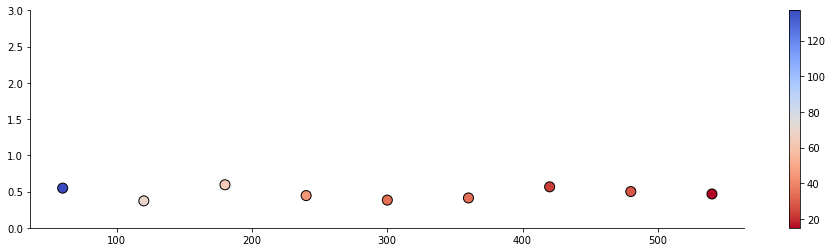

In [177]:
plot_mood_on_time(ema,"lonely",interval=60)

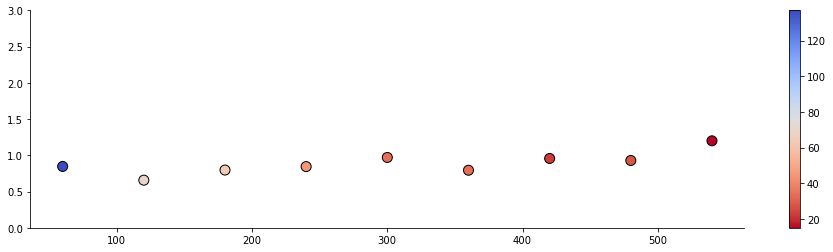

In [176]:
plot_mood_on_time(ema,"stress",interval=60)

<div class="alert alert-block alert-danger">

There does not seem to be a major relationship between the mood and the amount of time spent at home.
    
</div>

### Time at Home and Exposure
We can now use the time at home and see if the exposure to IEQ parameters factors into the mood that participants report.

In [106]:
def get_inhalation_rate(pt):
    """
    Gets inhalation rates for the given participant using EPA data:
    source: www.epa.gov/sites/default/files/2015-09/documents/efh-chapter06.pdf
    
    Parameters
    ----------
    pt : str
        Beiwe ID
    
    Returns
    -------
    <rate> : float
        inhalation rate in liters/minute
    """
    info = pd.read_excel("../data/raw/utx000/admin/id_crossover.xlsx")
    mass = info[info["beiwe"] == pt]["mass"].values[0]
    sex = info[info["beiwe"] == pt]["sex"].values[0]
    if sex[0].lower() == "m": # male rate
        return 6.2e-5 * 1000 * mass
    elif sex[0].lower() == "f": # female rate
        return 6.2e-5 * 1000 * mass
    else:
        return np.nan

In [107]:
def convert_exposure(iaq_param,value):
    """
    Converts the IAQ parameter into more digestible units
    
    Parameters
    ----------
    iaq_param : {"co2","pm2p5","tvoc"}
        specifies which IAQ parameter to convert
    value : float
        value of the corresponding IAQ parameter in "standard" units
    
    Returns
    -------
    <output> : float
        converted parameter value
    """
    vol_air = 24.45
    
    if iaq_param == "co2":
        return value / 10e6 / vol_air * 44 * 1000
    elif iaq_param == "pm2p5": # assuming mass for now
        return value / 1000 / 1000
    elif iaq_param == "tvoc":
        return value / 10e9 / vol_air
    else:
        return value

In [108]:
def get_exposure(df,exposure_min_t=0,exposure_max_t=180,summary_stat="mean",convert=False,scale=False):
    """
    Calculates the concentration exposure amount over a given interval
    
    Parameters
    ----------
    df : DataFrame
        Must contain columns {"beiwe","time_at_home"} and at least one column with IEQ parameters
        ending in the provided summary_stat
    exposure_min_t : int, default 0
        MINIMUM exposure period (in minutes) i.e. minimum time at home before submitting EMA
    exposure_max_t : int, default 180
        MAXIMUM exposure period (in minutes) i.e. maximum time at home before submitting EMA
    summary_stat : {"mean","delta","max","sum"}, default "mean"
        IEQ summary stat to consider 
    
    Returns
    -------
    df_exposure : DataFrame 
        Original datafame with calculated exposure concentrations for IEQ parameters as
        separate columns
    """
    df["mins_at_home"] = df["time_at_home"] / 60
    df = df[(df["mins_at_home"] >= exposure_min_t) & (df["mins_at_home"] <= exposure_max_t)]
    df_exposure = df.copy()
    for ieq_param in [c for c in df.columns if c.endswith(summary_stat)]:
        ieq_param_short = ieq_param.split("_")[0]
        if ieq_param_short in ["co2","tvoc","co","no2","pm2p5"]:
            if convert:
                df[ieq_param] = df.apply(lambda row: convert_exposure(ieq_param_short,row[ieq_param]),axis=1)
            if scale:
                df["in_rate"] = df.apply(lambda row: get_inhalation_rate(row["beiwe"]),axis=1)
                df_exposure[f'{ieq_param.split("_")[0]}_exposure'] = df[ieq_param] * df["in_rate"]
            else:
                df_exposure[f'{ieq_param.split("_")[0]}_exposure'] = df[ieq_param]
        else: # temperature or rh
            df_exposure[f'{ieq_param.split("_")[0]}_exposure'] = df[ieq_param]
        
    df_exposure.drop([col for col in df_exposure.columns if col.split("_")[-1] in ["mean","delta","max","sum"]],axis="columns",inplace=True)
    return df_exposure

In [109]:
#temp = get_exposure(ema_ieq,summary_stat="sum",convert=False)
#temp.head()

In [110]:
def plot_exposure_violin(df,mood="content",ieq_param="co2"):
    """Plots the distribution of exposure (mean*hours at home) for the given mood scores"""
    _, ax = plt.subplots(figsize=(8,4))
    sns.violinplot(x=mood,y=f"{ieq_param}_exposure",data=df,
                   cut=0,inner=None,scale="area",ax=ax)
    ax.set_xlabel(mood.title())
    ax.set_ylabel(f"{ieq_param.upper()} Exposure (concentration-hours)")
    for loc in ["top","right"]:
        ax.spines[loc].set_visible(False)

    plt.show()
    plt.close()

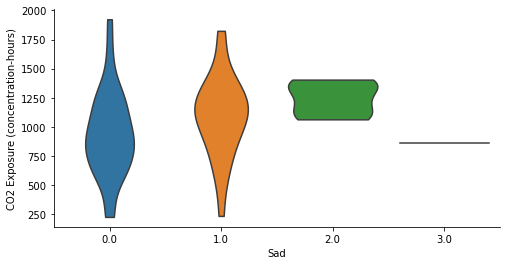

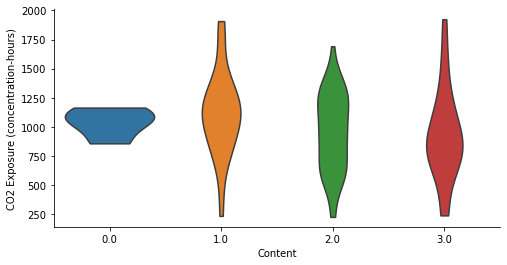

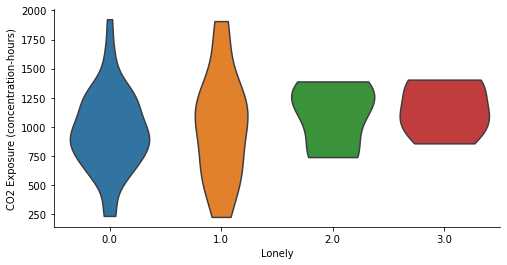

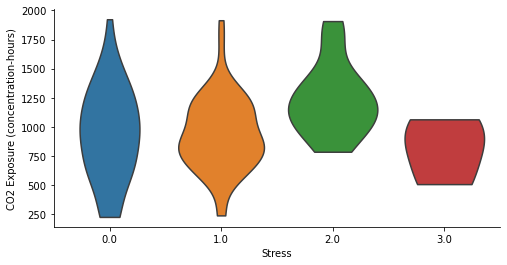

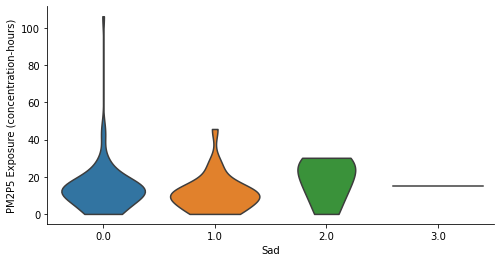

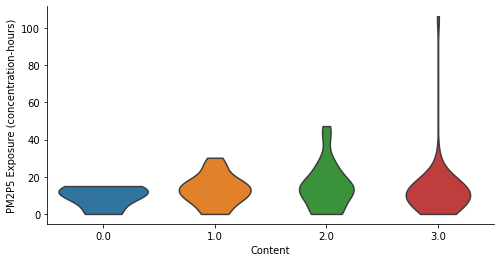

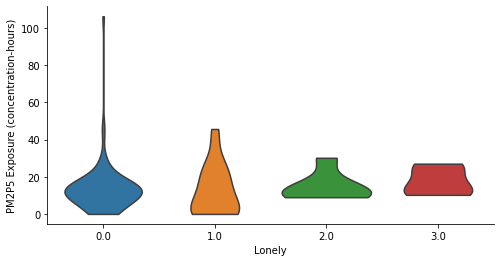

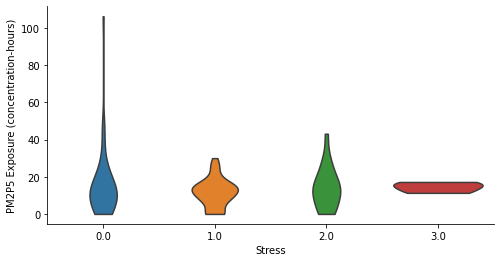

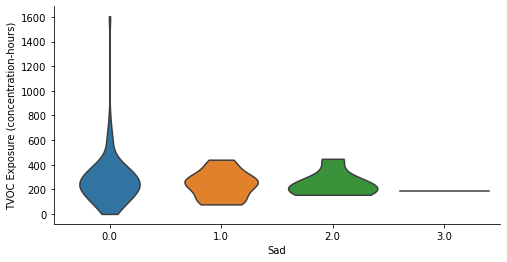

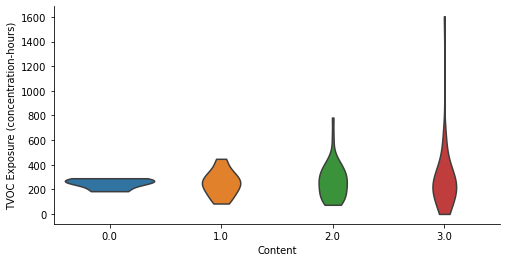

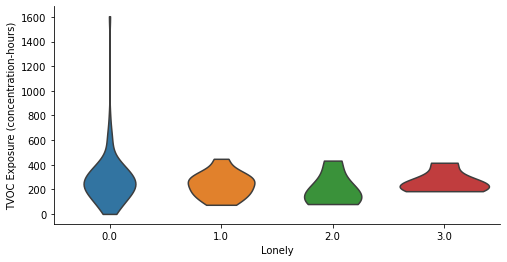

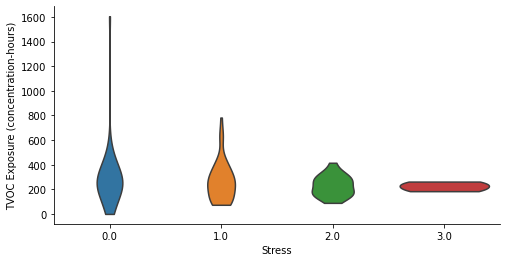

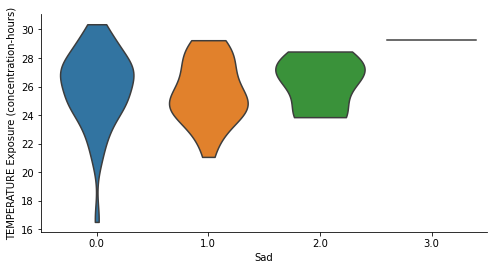

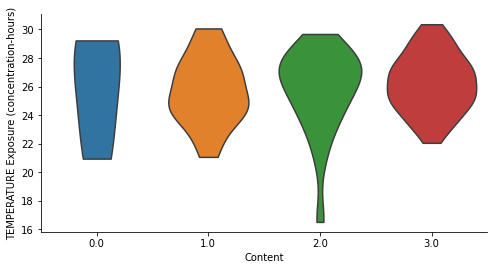

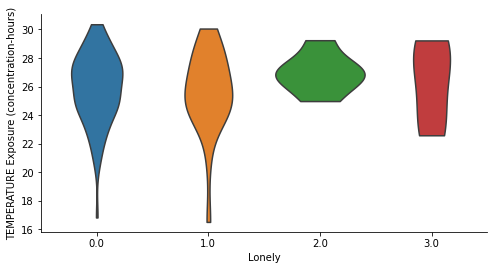

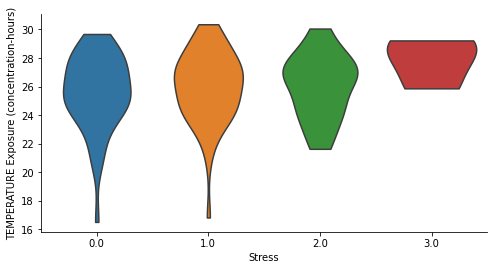

In [111]:
for ieq_param in ["co2","pm2p5","tvoc","temperature"]:
    for mood in ["sad","content","lonely","stress"]:
        plot_exposure_violin(get_exposure(ema_ieq), mood=mood,ieq_param=ieq_param)

In [112]:
def plot_exposure_bimood_violin(df_in,ieq_params=["co2","tvoc","pm2p5","temperature","rh"],moods=["discontent","stress","lonely","sad"]):
    """"""
    legend_fs = 22
    tick_fs = 24
    label_fs = 26
    title_fs = 32
    # creating dictionary to store p-values
    ttest_results = {}
    fig, axes = plt.subplots(len(ieq_params),1,figsize=(4*len(moods),4*len(ieq_params)),sharex=True)
    for ieq_param, title, ax in zip(ieq_params,["a","b","c","d","e","f"],axes.flat):
        df_expanded = df_in.melt(id_vars=[c for c in df_in.columns if c.endswith("exposure")],value_vars=moods)
        #return df_expanded
        sns.violinplot(x="variable",y=f"{ieq_param}_exposure",hue="value",data=df_expanded,
                       split=True,inner=None,hue_order=["low","high"],palette={"low":"white","high":"#bf5700"},cut=0,ax=ax)
        # x-axis
        ax.set_xticklabels([mood.title() for mood in moods],fontsize=tick_fs)
        ax.set_xlabel("")
        # y-axis
        plt.setp(ax.get_yticklabels(), ha="right", rotation=0, fontsize=tick_fs)
        ax.set_ylabel(visualize.get_label(ieq_param),fontsize=label_fs)
        # remainder
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
        if ieq_param == "rh":
            ax.legend(loc="upper center",bbox_to_anchor=(0.5,-0.075),frameon=False,ncol=2,fontsize=legend_fs,title_fontsize=tick_fs,title="Mood Score")
        else:
            ax.get_legend().remove()
        
        pvals = pd.DataFrame()
        for mood in moods:
            df = df_expanded[df_expanded["variable"] == mood]
            low_vals = df[df["value"] == "low"]
            high_vals = df[df["value"] == "high"]
            #print(f"Number of high:\t{len(high_vals)}\nNumber of low:\t{len(low_vals)}")
            _, p = stats.ttest_ind(low_vals[f"{ieq_param}_exposure"],high_vals[f"{ieq_param}_exposure"], equal_var=True, nan_policy="omit")
            pvals = pvals.append(pd.DataFrame({"mood":[mood],"low":[len(low_vals)],"high":[len(high_vals)],
                                               "mean_low":[np.nanmean(low_vals[f"{ieq_param}_exposure"])],"mean_high":np.nanmean(high_vals[f"{ieq_param}_exposure"]),"p_val":[p]}))

        ttest_results[ieq_param] = pvals.set_index("mood")

        # Annotating with p-values
        xlocs = ax.get_xticks()
        ax.text(ax.get_xlim()[0],ax.get_ylim()[1],"          p:",ha="center",va="bottom",fontsize=tick_fs)
        for xloc, p in zip(xlocs,ttest_results[ieq_param]["p_val"]):
            weight="bold" if p < 0.05 else "normal"
            val = round(p,3) if p > 0.001 else "< 0.001"
            ax.text(xloc,ax.get_ylim()[1],val,fontsize=tick_fs,ha="center",va="bottom",weight=weight)
        
    plt.show()
    plt.close()
    
    return ttest_results

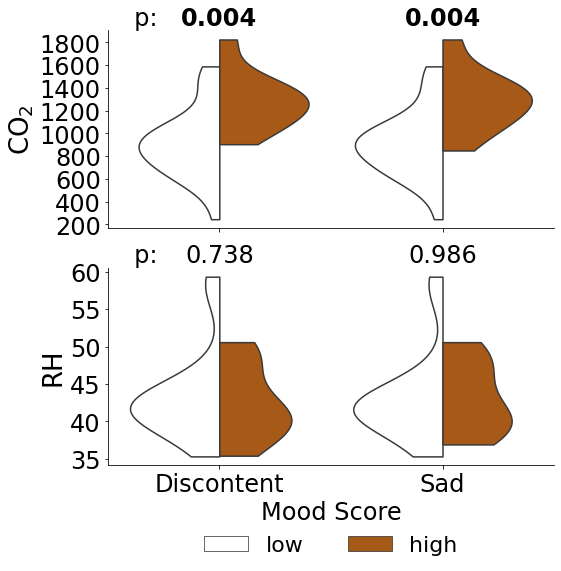

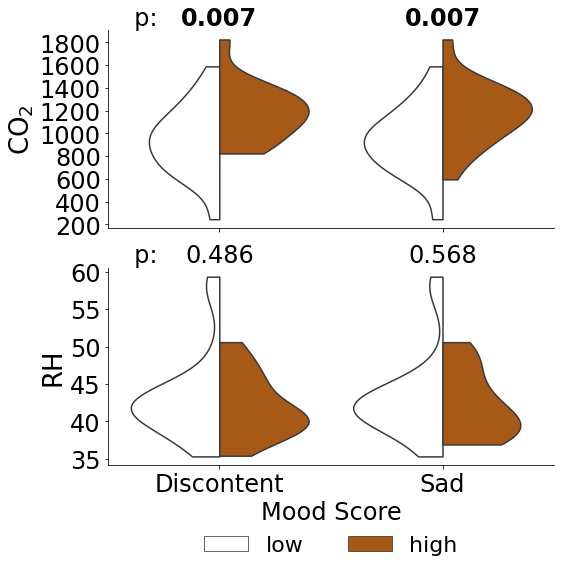

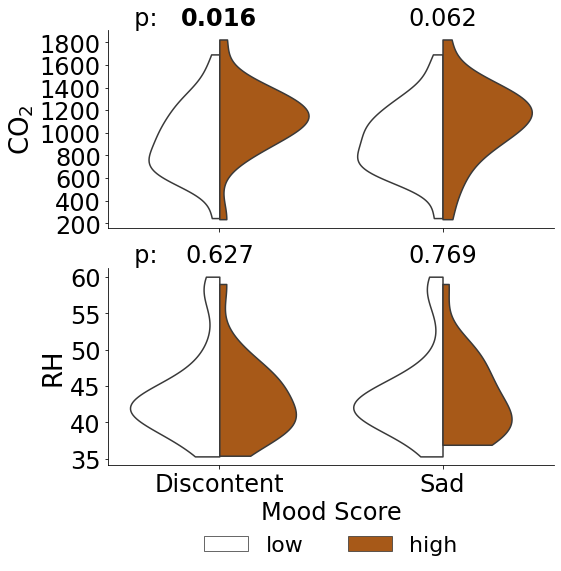

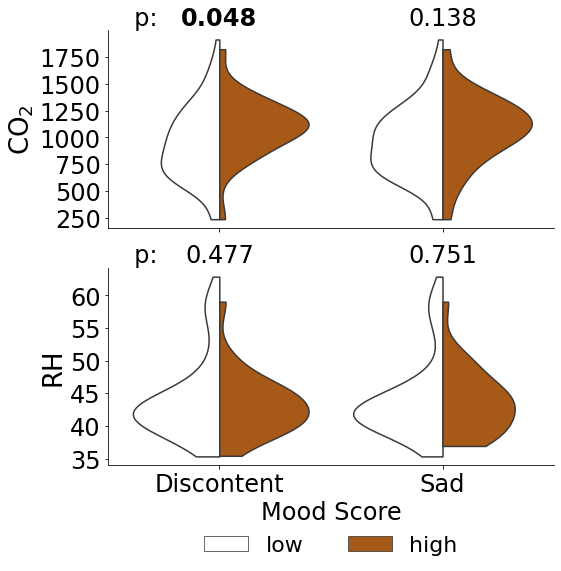

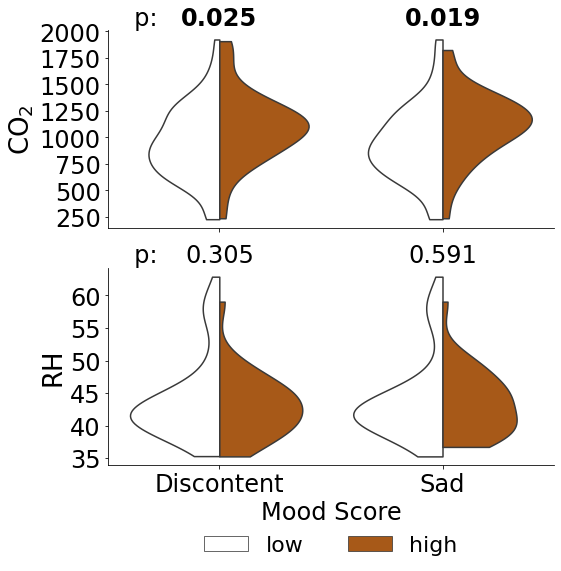

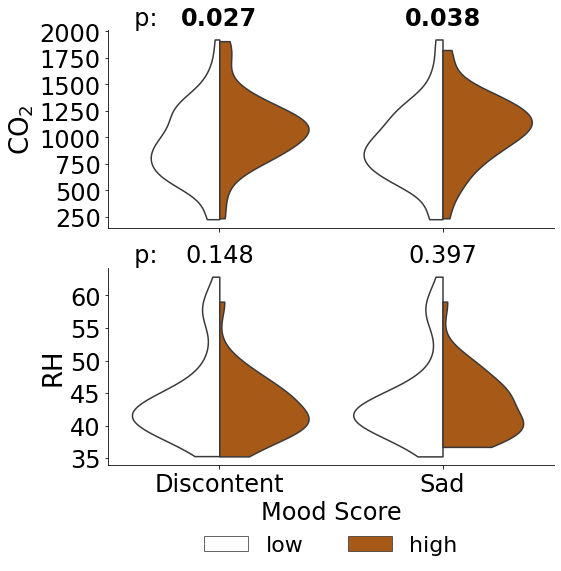

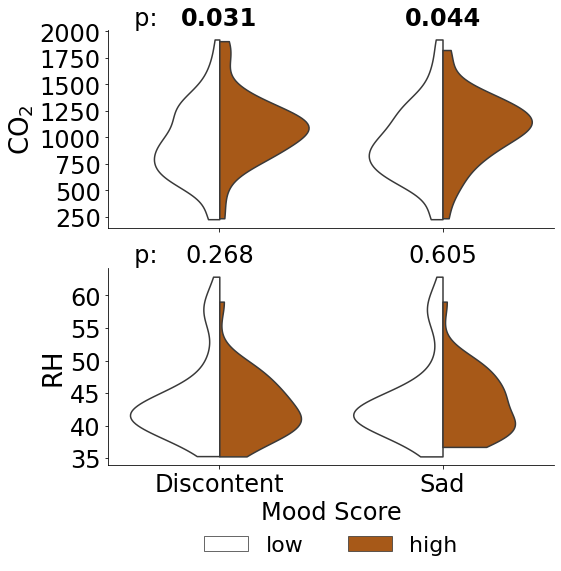

In [184]:
for t in [30,60,90,120,180,210,240]:
    res = plot_exposure_bimood_violin(get_exposure(ema_bi_ieq,exposure_max_t=t,summary_stat="mean"),ieq_params=["co2","rh"],moods=["discontent","sad"])

In [114]:
res

{'co2':             low  high    mean_low   mean_high     p_val
 mood                                                   
 discontent   96    41  245.253548  450.799989  0.040041
 stress       53    84  275.273917  327.935894  0.590902
 lonely       85    52  293.641736  342.638156  0.631011
 sad          91    46  329.003746  267.227557  0.538345,
 'tvoc':             low  high    mean_low   mean_high     p_val
 mood                                                   
 discontent   96    41  269.527015  267.813438  0.988871
 stress       53    84  303.811340  248.124111  0.632806
 lonely       85    52  284.933584  232.468955  0.669070
 sad          91    46  313.624116  174.814756  0.248161,
 'pm2p5':             low  high   mean_low  mean_high     p_val
 mood                                                 
 discontent   96    41  18.189310  15.788942  0.831262
 stress       53    84  27.869941  11.215038  0.115385
 lonely       85    52  18.910084  14.135401  0.671478
 sad          9

<div class="alert alert-block alert-success">

The only relationship that shows a significant relationship throughout the various exposure periods is `co2` and the level of discontent. This relationship is also evident to a lesser degrees for `sad`.
    
</div>

[Back to Analysis](#analysis)

---

<a id='contigency'></a>

## Contigency Tables
With the contigency tables, we address any participant bias that might have slipped into the previous analysis because of one participant having better or worse IAQ conditions.

With both mood and IEQ binarized, we can create the contigency tables and visualize them. Python even has a built-in function for this: [crosstab](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html).

See more [here](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

We try two metrics on the contigency table:
1. Matthews Correlation Coefficient (also called the Phi Coefficient)
2. Cramer's V

Turns out these metrics are essentially the same with Cramer's V taking the absolute value of the Matthews Coefficient.

In [115]:
from sklearn.metrics import matthews_corrcoef
import scipy.stats as stats

In [116]:
def calculate_cramers_v(ct):
    """returns Cramers V from the given contingency table"""
    #create 2x2 table
    data = ct.values

    #Chi-squared test statistic, sample size, and minimum of rows and columns
    X2 = stats.chi2_contingency(data, correction=False)[0]
    n = np.sum(data)
    minDim = min(data.shape)-1

    #calculate Cramer's V 
    V = np.sqrt((X2/n) / minDim)

    #display Cramer's V
    return V

Getting Contigency Tables and calculating scores.

In [121]:
for mood in ["discontent","sad","lonely","stress"]:
    print(mood.upper())
    #for ieq_param in ["co2","tvoc","pm2p5_mass","temperature_c","rh"]:
    ct = pd.crosstab(columns=ema_bi_ieq_bi[mood],index=[ema_bi_ieq_bi[f"co2_binary"],ema_bi_ieq_bi[f"temperature_c_binary"],ema_bi_ieq_bi[f"pm2p5_mass_binary"],ema_bi_ieq_bi[f"rh_binary"],ema_bi_ieq_bi[f"tvoc_binary"]])
    #print(matthews_corrcoef(ema_bi_ieq_bi[mood],ema_bi_ieq_bi[f"{ieq_param}_binary"]))
    print(round(calculate_cramers_v(ct),3))#,"\t-\t",ieq_param)
    #print(ct)
    print()

DISCONTENT
0.208

SAD
0.21

LONELY
0.232

STRESS
0.22



[Back to Analysis](#analysis)

---

<a id='mood_and_ach'></a>

## Mood and Ventilation
We scatter the summarized mood scores over the study period versus the average ventilation rate determined from the carbon dioxide concentrations.

In [118]:
ach = pd.read_csv("../data/processed/beacon-ventilation_from_ss.csv")

In [119]:
def scatter_ach_and_mood(ach, mood, summary_stat="mean"):
    """"""
    # how to summarize the mood scores
    if summary_stat == "median":
        mood_pt = mood.groupby("beiwe").median()
    elif summary_stat == "std":
        mood_pt = mood.groupby("beiwe").std()
    else:
        mood_pt = mood.groupby("beiwe").mean()
        
    # always averaging the ventilation rates
    ach_pt = ach.groupby("beiwe").std()["ach"]
    
    # merging
    merged = mood_pt[["content","stress","lonely","sad"]].merge(right=ach_pt,left_index=True,right_index=True)
    
    # scattering
    fig, axes = plt.subplots(1,4,figsize=(12,3),sharey=True)
    for m, ax in zip(["content","sad","lonely","stress"],axes.flat):
        ax.scatter(merged["ach"],merged[m],s=50,color="black")
        # x-axis
        ax.set_xlabel("Ventilation Rate (h$^{-1}$)")
        # remainder
        ax.set_title(m.title())
        for loc in ["top","right"]:
            ax.spines[loc].set_visible(False)
            
    # y-axis
    axes[0].set_ylabel(f"Mood Scored ({summary_stat})")
    plt.show()
    plt.close()
    
    return merged

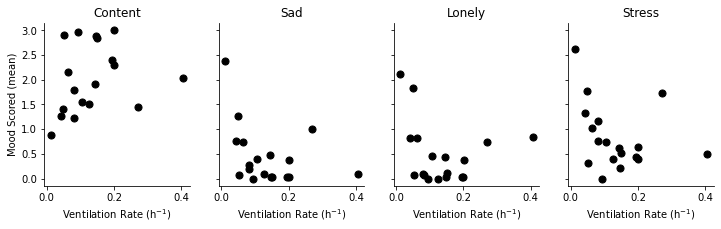

,content,stress,lonely,sad,ach
beiwe,,,,,
745vq78e,2.906250,0.312500,0.062500,0.062500,0.053160
9jtzsuu8,1.516129,0.387097,0.000000,0.096774,0.126161
9xmhtq74,2.972973,0.000000,0.000000,0.000000,0.093973
awa8uces,1.219512,1.170732,0.097561,0.195122,0.081519
e73a1pd5,0.875000,2.625000,2.125000,2.375000,0.012665
i31pt4b4,2.156250,1.031250,0.812500,0.750000,0.063641
idbkjh8u,1.550000,0.750000,0.450000,0.400000,0.106068
kyj367pi,2.041667,0.500000,0.833333,0.083333,0.405498
lkkjddam,1.451613,1.741935,0.741935,1.000000,0.270075


In [120]:
scatter_ach_and_mood(ach,ema,summary_stat="mean")

[Return to Analysis](#analysis)